# Fake News Classification

Download the news dataset from the Datasets directory.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.sparse as sp

from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from copy import deepcopy
from typing import Callable, List, Tuple, Any, Dict
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.metrics import confusion_matrix
from IPython.display import display, HTML
from sklearn.model_selection import KFold

### Preprocessing

In [2]:
fake_news_data = pd.read_csv('Datasets/news_data/Fake.csv')
true_news_data = pd.read_csv('Datasets/news_data/True.csv')

In [3]:
fake_news_data.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [4]:
true_news_data.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [5]:
true_news_data.shape

(21417, 4)

In [6]:
fake_news_data.shape

(23481, 4)

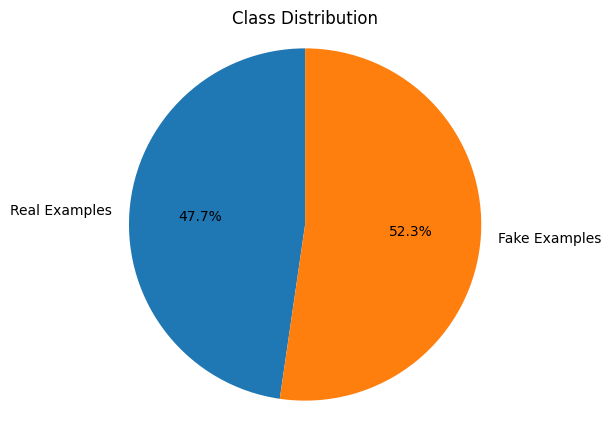

In [7]:
fig = plt.figure(figsize=(5, 5))
labels = 'Real Examples', 'Fake Examples'
sizes = [len(true_news_data), len(fake_news_data)] 

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  
plt.title('Class Distribution')
plt.show()

This dataset contains a relatively even distribution of positive and negative examples. 

In [8]:
# add labels to datasets
fake_news_data['class'] = 1
true_news_data['class'] = 0

In [9]:
# append dataframes and shuffle
news_df = pd.concat([true_news_data, fake_news_data], ignore_index=True)
news_df = news_df.sample(frac=1).reset_index(drop=True)
news_df.shape

(44898, 5)

In [10]:
news_df.head()

,title,text,subject,date,class
0,Mnangagwa told Mugabe he will be safe in Zimba...,HARARE (Reuters) - Incoming Zimbabwe leader Em...,worldnews,"November 24, 2017",0
1,Trump's Supreme Court nominee questions power ...,NEW YORK (Reuters) - Supreme Court nominee Jud...,politicsNews,"February 1, 2017",0
2,"This Traditionally Red State Is Going Blue, N...",Remember back in May when Donald Trump said he...,News,"October 19, 2016",1
3,The FBI Just Announced The Results Of Their I...,"At 11 AM Tuesday morning, FBI Director James C...",News,"July 5, 2016",1
4,VIDEO SURFACES OF DISGRACED Alleged Pedophile ...,"Earlier today, it was reported by TMZ that an ...",politics,"Oct 30, 2017",1


In [11]:
# create a vectorizer with a max of 50 features 
vectorizer = TfidfVectorizer(stop_words='english', max_features=50)

# create a copy of the dataset and extract the titles column and class labels
# NOTE: the text column will be added in a later cell.
news_df_2 = deepcopy(news_df)
title_labels = news_df_2['class']
titles_df = news_df_2['title']

# split train/test data
x_train, x_test, y_train, y_test = train_test_split(titles_df, title_labels, test_size=0.20, random_state=14)

# transform title column
titles_train = vectorizer.fit_transform(x_train)
titles_test = vectorizer.transform(x_test)

# scale features
scaler = StandardScaler(with_mean=False)
titles_train = scaler.fit_transform(titles_train)
titles_test = scaler.transform(titles_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# visualize the 50 features selected
features = vectorizer.get_feature_names_out()
print(f"Features:\n{features}")

Features:
['america' 'anti' 'black' 'breaking' 'calls' 'campaign' 'china' 'clinton'
 'cnn' 'court' 'deal' 'democrats' 'donald' 'election' 'eu' 'fbi' 'gets'
 'gop' 'government' 'hillary' 'house' 'iran' 'just' 'korea' 'media'
 'muslim' 'new' 'news' 'north' 'obama' 'party' 'people' 'police'
 'president' 'republican' 'republicans' 'russia' 'russian' 'says' 'senate'
 'state' 'syria' 'tax' 'trump' 'tweets' 'video' 'vote' 'war' 'watch'
 'white']


### Test a Naive Bayes Classifier to check the pipeline

In [12]:
naive_bayes = GaussianNB()
nb_model = naive_bayes.fit(titles_train.toarray(), y_train)
nb_train_predictions = nb_model.predict(titles_train.toarray())
nb_test_predictions = nb_model.predict(titles_test.toarray())
print("Naive Bayes Classifier:")
print(f"Training Accuracy: {round(100 * accuracy_score(y_train, nb_train_predictions), 2)}%", end=" ")
print(f"Test Accuracy: {round(100 *accuracy_score(y_test, nb_test_predictions), 2)}%")

Naive Bayes Classifier:
Training Accuracy: 80.61% Test Accuracy: 80.19%


### Helper Functions

<a id="annot"></a>
## annot
*The annot function was provided by Dr. Guven in the module four notebook. This function adds an operating point annotation to the ROC plots.*  **Used by**: [plot_roc](#plot_roc)

* **opi** int: the index of the operating point in the results lists
* **_x** float: the FPR for the operating point
* **_y** float: the TPr for the operating point

**returns** None.

In [13]:
# annot code by E. Guven module 4 notebook
def annot(opi: int, _x: float, _y: float) -> None:
    plt.annotate(f"OP{opi}", xy=(_x, _y), xytext=(.90*_x+.1, .80*_y), arrowprops=dict(facecolor='lightgray', shrink=1))

<a id="plot_roc"></a>
## plot_roc
*The plot_roc function was provided by Dr. Guven in the module four notebook. This function plots the ROC curve for a model tested with different hyperparameters. The model also adds annotations to the plots at the provided operating points indices.*

* **FPR** List[float]: a list of false positive rates for the different experiments
* **TPR** List[float]: a list of true positive rates for the different experiments
* **annotate_indices** List[int]: a list of indices for operating points to annotate

**returns** None.

In [14]:
# plot_roc code by E. Guven module 4 notebook
def plot_roc(FPR: List[float], TPR: List[float], annotate_indices: List[int]) -> None:
    # sorts the points to display nicely on ROC
    FPR, TPR = zip(*sorted(zip(FPR, TPR)))
    fpr = [0.]+list(FPR)+[1.]; tpr = [0.]+list(TPR)+[1.]

    # plot
    fig, ax = plt.subplots(dpi=72)
    plt.plot(fpr, tpr, ':', label='ROC')
    plt.scatter(FPR, TPR, 50, color='red', marker='o', label='operating points')
    plt.plot([0, 1], [0, 1], linestyle='--', color=(0.6, 0.6, 0.6), label='coin flip')

    # annotate some data points
    for i in annotate_indices:
        annot(i, fpr[i], tpr[i])
    

    # labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

<a id="get_annot_indices"></a>
## get_annot_indices
*The get_annot_indices function returns the indices of the operating points with minimum accuracy, maximum accuracy, and maximum TPR.*

* **acc** List[float]: a list of accuracies for the different experiments
* **TPR** List[float]: a list of true positive rates for the different experiments
* **annotate_indices** List[int]: a list of indices for operating points to annotate

**returns** None.

In [15]:
def get_annot_indices(acc, TPR):
    annot_indices = []
    annot_indices.append(acc.index(min(acc)))
    annot_indices.append(acc.index(max(acc)))
    annot_indices.append(TPR.index(max(TPR)))
    return annot_indices

<a id="plot_multi_roc"></a>
## plot_multi_roc
*The plot_multi_roc function displays the ROC curves for multiple models on the same plot.*

* **roc_data** Dict[str, Tuple[List[float]]]: the roc_data is a dictionary with the models as the keys and a tuple containing (FPRs, TPRs) for the values. 

**returns** None.

In [16]:
def plot_multi_roc(roc_data: Dict[str, Tuple[List[float]]]) -> None:
    fig, ax = plt.subplots(dpi=72)
    
    # plotting the coin flip line
    plt.plot([0, 1], [0, 1], linestyle='--', color=(0.6, 0.6, 0.6), label='coin flip')
    
    # loop through each model's ROC data and plot
    for model_name, (FPR, TPR) in roc_data.items():
        FPR, TPR = zip(*sorted(zip(FPR, TPR)))
        fpr = [0.] + list(FPR) + [1.]
        tpr = [0.] + list(TPR) + [1.]
    
        plt.plot(fpr, tpr, label=model_name)
        
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

<a id="decision_tree"></a>
## decision_tree

*The decision_tree function trains and evaluates a decision tree using the provided training and test sets. The function returns the accuracy, tn, fp, fn, tp for the test set.*

* **x_train np.array:** the training dataset
* **y_train np.array:** the training labels
* **x_test np.array:** the testing dataset
* **y_test np.array:** the testing labels
* **params Dict[str, Any]:** a dictionary of parameters to pass to the model function

returns Tuple[float | int]

In [17]:
def decision_tree(x_train: np.array, x_test: np.array, y_train: np.array, y_test: np.array, params: Dict[str, Any]) -> Tuple[float | int]:
    # get hyperparameters
    depth = None
    num_features = None
    if "max_depth" in params:
        depth = params["max_depth"]
    if "max_features" in params:
        num_features = params["max_features"]
        
    # initialize and train the model 
    decision_tree = tree.DecisionTreeClassifier(max_depth = depth, max_features = num_features)
    tree_model = decision_tree.fit(x_train, y_train)
    
    # get predictions
    test_predictions = tree_model.predict(x_test)
    # get evaluation metrics
    test_accuracy = round(100 * accuracy_score(y_test, test_predictions), 3)
    tn, fp, fn, tp = confusion_matrix(y_test, test_predictions).ravel()
       
    return test_accuracy, tn, fp, fn, tp

<a id="random_forest"></a>
## random_forest

*The random_forest function trains and evaluates a random forest classifier using the provided training and test sets. The function returns the accuracy, tn, fp, fn, tp for the test set.*

* **x_train np.array:** the training dataset
* **y_train np.array:** the training labels
* **x_test np.array:** the testing dataset
* **y_test np.array:** the testing labels
* **params Dict[str, Any]:** a dictionary of parameters to pass to the model function

returns Tuple[float | int]

In [18]:
def random_forest(x_train: np.array, x_test: np.array, y_train: np.array, y_test: np.array, params: Dict[str, Any]) -> Tuple[float | int]:
    # get hyperparameters
    depth = None
    num_features = None
    estimators = None
    
    if "max_depth" in params:
        depth = params["max_depth"]
    if "max_features" in params:
        num_features = params["max_features"]
    if "n_estimators" in params:
        estimators = params["n_estimators"]
    
    # initialize and train the model
    forest = RandomForestClassifier(n_estimators=estimators, 
                                    max_depth=depth, 
                                    max_features = num_features, 
                                    random_state=0, 
                                    n_jobs=4)
    forest.fit(x_train, y_train)
    
    # get test predictions 
    test_predictions = forest.predict(x_test)
    # get evaluatin metrics
    test_accuracy = round(100 * accuracy_score(y_test, test_predictions), 3)
    tn, fp, fn, tp = confusion_matrix(y_test, test_predictions).ravel()
 
    return test_accuracy, tn, fp, fn, tp

<a id="MLP"></a>
## MLP

*The MLP function trains and evaluates a multilayer perceptron using the provided training and test sets. The function returns the accuracy, tn, fp, fn, tp for the test set.*

* **x_train np.array:** the training dataset
* **y_train np.array:** the training labels
* **x_test np.array:** the testing dataset
* **y_test np.array:** the testing labels
* **params Dict[str, Any]:** a dictionary of parameters to pass to the model function

returns Tuple[float | int]

In [19]:
def MLP(x_train: np.array, x_test: np.array, y_train: np.array, y_test: np.array, params: Dict[str, Any]) -> Tuple[float | int]:
    # set some defaults and get the hyperparameters
    layer_size = (10,)
    learning_rate = 0.001
    max_iterations = 1000
    
    if "max_iterations" in params:
        max_iterations = params["max_iterations"]
    if "learning_rate_init" in params:
        learning_rate = params["learning_rate_init"]
    if "layer_size" in params:
        layer_size = params["layer_size"]
    
    
    # initialize and train the model
    mlp = MLPClassifier(random_state=1, 
                        max_iter=max_iterations, 
                        solver='sgd', 
                        hidden_layer_sizes=layer_size, 
                        learning_rate='adaptive',
                        learning_rate_init=learning_rate)
    
    mlp.fit(x_train, y_train)
    
    # get predictions
    test_predictions = mlp.predict(x_test)
    # get evaluation metrics
    test_accuracy = round(100 * accuracy_score(y_test, test_predictions), 3)
    tn, fp, fn, tp = confusion_matrix(y_test, test_predictions).ravel()
 
    return test_accuracy, round(tn, 3), round(fp, 3), round(fn, 3), round(tp, 3)

<a id="format_results"></a>
## format_results
*The format_results function formats the accuracies, true positive rates, and false positive rates in a dataframe with the corresponding parameters for easy visualization.*

* **parameter_names** List[str]: a list of parameters used
* **parameters** Dict[str, Any]: the parameters used for each experiment
* **accuracies** List[float]: a list of accuracies for the different models
* **FPR** List[float]: a list of false positive rates for the different experiments
* **TPR** List[float]: a list of true positive rates for the different experiments

**returns** pd.DataFrame.

In [20]:
def format_results(parameter_names: List[str], parameters: Dict[str, Any], accuracies: List[float], TPR: List[float], FPR: List[float]) -> pd.DataFrame:
    df = pd.DataFrame()
    df["% Accuracy"] = accuracies
    df["TPR"] = TPR
    df["FPR"] = FPR
    for parameter in parameter_names:
        df[parameter] = [val[parameter] for val in parameters]
    return df

<a id="display_results"></a>
## display_results
*The display_results function adds some html to provide a better visualization of the results dataframe.*

* **df** pd.DataFrame: the dataframe of results
* **title** str: the dataframe title

**returns** None.

In [21]:
def display_results(df: pd.DataFrame, title: str) -> None:
    title_html = f"<h4 style='text-align:center;'>{title}</h4>"
    df_html = df.to_html(index=False)
    combined = f"<div style='display:inline-block;'>{title_html}{df_html}</div>"
    display(HTML(combined))

## Model Evaluation with ROC Curves

### Decision Tree

In [22]:
# initialize test parameters
d = [3, 7, 13]
max_features = [3, 6, 12, 20]
dt_TPR, dt_FPR, dt_acc, dt_params = [], [], [], []

# run experiments using 5-fold validation 
for depth in d:
    for num in max_features:
        # run k-fold
        kf = KFold(n_splits=5, random_state=1, shuffle=True)
        accs, TPRs, FPRs = [], [], []
        
        for i, (train_index, test_index) in enumerate(kf.split(titles_train, y_train)):
            accuracy, tn, fp, fn, tp = decision_tree(titles_train[train_index], 
                                                     titles_train[test_index], 
                                                     y_train[train_index], 
                                                     y_train[test_index], 
                                                     {"max_depth": depth, 
                                                      "max_features": num})
            accs.append(accuracy)
            TPRs.append(tp/(tp+fn))
            FPRs.append(fp/(fp+tn))
             
        dt_params.append({"max_depth": depth, "max_features": num})
        dt_acc.append(sum(accs)/len(accs))
        dt_TPR.append(sum(TPRs)/len(TPRs))
        dt_FPR.append(sum(FPRs)/len(FPRs))  

In [23]:
results = format_results(["max_depth", "max_features"], dt_params, dt_acc, dt_TPR, dt_FPR)
display_results(results, "Decision Tree Results")

% Accuracy,TPR,FPR,max_depth,max_features
54.4462,0.820595,0.757346,3,3
65.6742,0.528565,0.196447,3,6
65.0008,0.489629,0.174799,3,12
70.2014,0.475460,0.046889,3,20
63.8594,0.335501,0.026668,7,3
68.5704,0.655571,0.283397,7,6
72.5098,0.496479,0.022994,7,12
75.4720,0.573675,0.045906,7,20
69.3746,0.467885,0.057939,13,3
72.3732,0.560647,0.096836,13,6


Number of operating points: 12


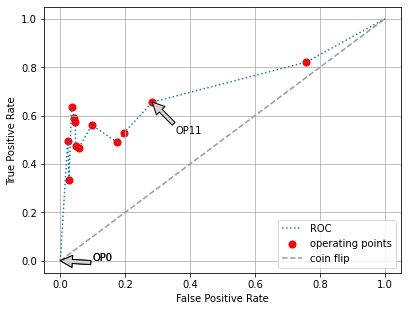

In [24]:
# get annotation incides for min acc, max acc, and max TPR
dt_annot_indices = get_annot_indices(dt_acc, dt_TPR)

print(f"Number of operating points: {len(dt_TPR)}")
plot_roc(dt_FPR, dt_TPR, dt_annot_indices)

### Random Forest

In [25]:
# initialize test hyperparameters
d = [3, 21]
max_features = [3, 12, 21]
estimators = [i for i in range(20, 100, 60)]

rf_TPR, rf_FPR, rf_acc, rf_params = [], [], [], []
# run experiments using 5-fold validation
for depth in d:
    for num in max_features:
        for est in estimators:
            kf = KFold(n_splits=5, random_state=1, shuffle=True)
            accs, TPRs, FPRs = [], [], []
            for i, (train_index, test_index) in enumerate(kf.split(titles_train, y_train)):
                accuracy, tn, fp, fn, tp = random_forest(titles_train[train_index], 
                                                         titles_train[test_index], 
                                                         y_train[train_index], 
                                                         y_train[test_index], 
                                                         {"max_depth": depth, 
                                                          "max_features": num,
                                                          "n_estimators": est})
                accs.append(accuracy)
                TPRs.append(tp/(tp+fn))
                FPRs.append(fp/(fp+tn))
                
            rf_params.append({"max_depth": depth, "max_features": num, "n_estimators": est})
            rf_acc.append(sum(accs)/len(accs))
            rf_TPR.append(sum(TPRs)/len(TPRs))
            rf_FPR.append(sum(FPRs)/len(FPRs))   

In [26]:
rf_results = format_results(["max_depth", "max_features", "n_estimators"], rf_params, rf_acc, rf_TPR, rf_FPR)
print(f"Number of operating points: {len(rf_TPR)}")
display_results(rf_results, "Random Forest Results")

Number of operating points: 12


% Accuracy,TPR,FPR,max_depth,max_features,n_estimators
74.2246,0.838001,0.362020,3,3,20
76.7078,0.823483,0.293214,3,3,80
77.4042,0.598971,0.032895,3,12,20
76.4602,0.576680,0.028152,3,12,80
73.2196,0.494568,0.005789,3,21,20
73.2280,0.494730,0.005789,3,21,80
81.5552,0.696812,0.053488,21,3,20
81.6026,0.698022,0.053854,21,3,80
81.2460,0.685763,0.047820,21,12,20
81.3520,0.687570,0.047591,21,12,80


Number of operating points: 12


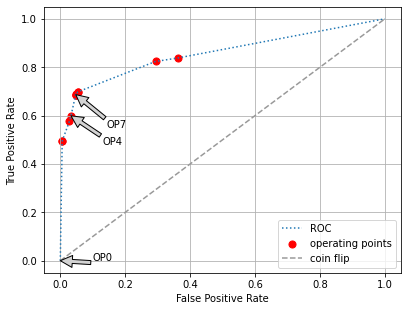

In [27]:
# get annotation indicies
rf_annot_indices = get_annot_indices(rf_acc, rf_TPR)

print(f"Number of operating points: {len(rf_TPR)}")
plot_roc(rf_FPR, rf_TPR, rf_annot_indices)

### Neural Network

In [28]:
# initialize test hyperparameters
layer_sizes = [(1, ), (5, ), (10, )]
learning_rates = [0.01, 0.0001, 0.00001]
max_iterations = [5000]

nn_TPR, nn_FPR, nn_acc, nn_params = [], [], [], []
# run experiments using 5-fold validation
for layer in layer_sizes:
    for lr in learning_rates:
        for max_iter in max_iterations:
            kf = KFold(n_splits=5, random_state=1, shuffle=True)
            accs, TPRs, FPRs = [], [], []

            for i, (train_index, test_index) in enumerate(kf.split(titles_train, y_train)):
                accuracy, tn, fp, fn, tp = MLP(titles_train[train_index], 
                                               titles_train[test_index], 
                                               y_train[train_index], 
                                               y_train[test_index],  
                                               {"layer_size": layer, 
                                                "learning_rate_init": lr,
                                                "max_iterations": max_iter})
                accs.append(accuracy)
                TPRs.append(tp/(tp+fn))
                FPRs.append(fp/(fp+tn))

            nn_params.append({"layer_size": layer, "learning_rate": lr, "max_iterations": max_iter})
            nn_acc.append(sum(accs)/len(accs))
            nn_TPR.append(sum(TPRs)/len(TPRs))
            nn_FPR.append(sum(FPRs)/len(FPRs)) 

In [29]:
nn_results = format_results(["layer_size", "learning_rate", "max_iterations"], nn_params, nn_acc, nn_TPR, nn_FPR)
print(f"Number of operating points: {len(nn_TPR)}")
display_results(nn_results, "Neural Network Results")

Number of operating points: 9


% Accuracy,TPR,FPR,layer_size,learning_rate,max_iterations
81.2070,0.703833,0.068621,"(1,)",0.01000,5000
81.3324,0.705709,0.068024,"(1,)",0.00010,5000
77.3986,0.635037,0.072852,"(1,)",0.00001,5000
81.5412,0.708697,0.066892,"(5,)",0.01000,5000
81.0234,0.708150,0.077222,"(5,)",0.00010,5000
77.0310,0.732801,0.188287,"(5,)",0.00001,5000
81.5412,0.713252,0.071954,"(10,)",0.01000,5000
80.9426,0.705756,0.076303,"(10,)",0.00010,5000
76.3098,0.776017,0.249725,"(10,)",0.00001,5000


Number of operating points: 9


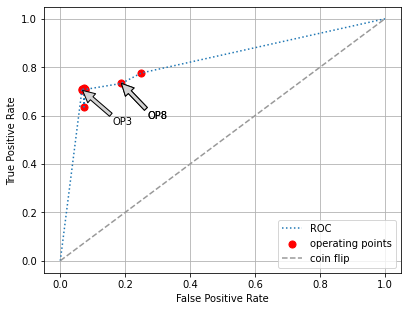

In [30]:
# get annotation indices
nn_annot_indices = get_annot_indices(nn_acc, nn_TPR)

print(f"Number of operating points: {len(nn_TPR)}")
plot_roc(nn_FPR, nn_TPR, nn_annot_indices)

### Display all models on the same plot

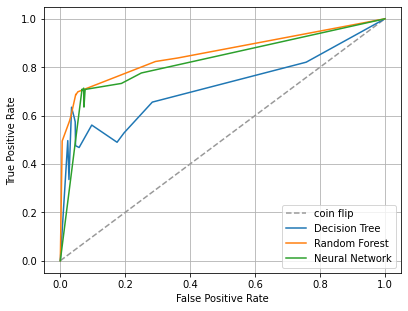

In [31]:
# plot the ROC curves on the same plot
model_roc_data = {
    'Decision Tree': (dt_FPR, dt_TPR),
    'Random Forest': (rf_FPR, rf_TPR),
    'Neural Network': (nn_FPR, nn_TPR)
}

plot_multi_roc(model_roc_data)

On an ROC plot, the probability of false alarm (pf) generally increases with the probability of detection (pd). The charts above demonstrate this behavior for the random forest and neural network models. The decision tree has some noise at the beginning of the ROC plot, where TPR decreases and FPR increases. However, the decision tree ROC curve generally follows the trend of pf increasing with pd. 

False positive predictions and false negative predictions both have adverse effects on the problem of classifying fake news. For example, both error cases could influence elections or cause people to believe inaccurate information about an infectious disease. If an article said that COVID-19 cases are increasing, and the model inaccurately classified this information as fake, people could spread COVID-19 faster by not wearing masks. Similarly, if an article said that COVID-19 is over, and the model inaccurately classified this as true, people could spread the disease faster. Therefore, the optimal classifier for this problem should have a high TPR and a low FPR. The accuracy metric shown in the results table provides a good second evaluation because the classes are balanced, and neither error case is more severe than the other. The results show that the accuracy metric agrees with the best trade-off between TPR and FPR.

Based on the above analysis, I would select the random forest model with a max_depth of 21, max_features of 3, and n_estimators of 20. This model had comparable performance to the random forest models that used a higher number of features and more trees. Therefore, the simpler model is preferred in this case. The neural network achieved comparable results with only a slightly higher TPR and a higher FPR. The decision tree did not perform as well as the other two models. The following section runs the selected random forest model on the test set for a final evaluation.

In [32]:
# run a final evaluation against the test set held-out during hyperparameter tuning
accuracy, tn, fp, fn, tp = random_forest(titles_train, 
                                         titles_test, 
                                         y_train, 
                                         y_test, 
                                         {"max_depth": 21, 
                                          "max_features": 3,
                                          "n_estimators": 20})

print(f"Accuracy: {accuracy}, TPR: {tp/(tp+fn)}, FPR: {fp/(fp+tn)}")

Accuracy: 81.247, TPR: 0.6896922745857542, FPR: 0.05585045003461805


### Test with the Title and Text Columns

In [33]:
# create a vectorizer with a max of 50 features 
vectorizer_titles = TfidfVectorizer(stop_words='english', max_features=50)
vectorizer_text = TfidfVectorizer(stop_words='english', max_features=50)

# create a copy of the dataset and extract the titles column and class labels
news_df_3 = deepcopy(news_df)
labels = news_df_3['class']
df = news_df_3.drop("class", axis=1)

# split train/test data
x_train, x_test, y_train_2, y_test_2 = train_test_split(df, labels, test_size=0.20, random_state=14)

# transform the text and title columns
train_titles = vectorizer_titles.fit_transform(x_train['title'])
train_text = vectorizer_text.fit_transform(x_train['text'])
test_titles = vectorizer_titles.transform(x_test['title'])
test_text = vectorizer_text.transform(x_test['text'])

# visualize the 50 features selected
titles_features = vectorizer_titles.get_feature_names_out()
print(f"Titles Features:\n{titles_features}")
text_features = vectorizer_text.get_feature_names_out()
print(f"Text Features:\n{text_features}")

Titles Features:
['america' 'anti' 'black' 'breaking' 'calls' 'campaign' 'china' 'clinton'
 'cnn' 'court' 'deal' 'democrats' 'donald' 'election' 'eu' 'fbi' 'gets'
 'gop' 'government' 'hillary' 'house' 'iran' 'just' 'korea' 'media'
 'muslim' 'new' 'news' 'north' 'obama' 'party' 'people' 'police'
 'president' 'republican' 'republicans' 'russia' 'russian' 'says' 'senate'
 'state' 'syria' 'tax' 'trump' 'tweets' 'video' 'vote' 'war' 'watch'
 'white']
Text Features:
['according' 'administration' 'america' 'american' 'campaign' 'clinton'
 'country' 'court' 'did' 'donald' 'election' 'going' 'government'
 'hillary' 'house' 'just' 'law' 'like' 'make' 'media' 'national' 'new'
 'news' 'obama' 'party' 'people' 'percent' 'police' 'political'
 'president' 'presidential' 'republican' 'republicans' 'reuters' 'right'
 'russia' 'said' 'say' 'security' 'state' 'states' 'time' 'told' 'trump'
 'twitter' 'united' 'washington' 'white' 'year' 'years']


In [34]:
# combine the features of both columns
train_data = sp.hstack([train_titles, train_text])
test_data = sp.hstack([test_titles, test_text])

y_train_2 = np.array(y_train_2)
y_test_2 = np.array(y_test_2)

# scale the data to apply the same preprocessing as the tests above
scaler = StandardScaler(with_mean=False)
titles_train = scaler.fit_transform(train_data)
titles_test = scaler.transform(test_data)

### Random Forest (title, text)

In [35]:
# initialize test hyperparameters
d = [3, 21]
max_features = [3, 12, 21]
estimators = [i for i in range(20, 100, 60)]

rf_TPR_2, rf_FPR_2, rf_acc_2, rf_params_2 = [], [], [], []
# run experiments using 5-fold validation
for depth in d:
    for num in max_features:
        for est in estimators:
            kf = KFold(n_splits=5, random_state=1, shuffle=True)
            accs, TPRs, FPRs = [], [], []

            for i, (train_index, test_index) in enumerate(kf.split(train_data, y_train_2)):
                accuracy, tn, fp, fn, tp = random_forest(train_data[train_index], 
                                                         train_data[test_index], 
                                                         y_train_2[train_index], 
                                                         y_train_2[test_index], 
                                                         {"max_depth": depth, 
                                                          "max_features": num,
                                                          "n_estimators": est})
                accs.append(accuracy)
                TPRs.append(tp/(tp+fn))
                FPRs.append(fp/(fp+tn))
                
            rf_params_2.append({"max_depth": depth, "max_features": num, "n_estimators": est})
            rf_acc_2.append(sum(accs)/len(accs))
            rf_TPR_2.append(sum(TPRs)/len(TPRs))
            rf_FPR_2.append(sum(FPRs)/len(FPRs))   

In [36]:
rf_results_2 = format_results(["max_depth", "max_features", "n_estimators"], rf_params_2, rf_acc_2, rf_TPR_2, rf_FPR_2)
print(f"Number of operating points: {len(rf_TPR_2)}")
display_results(rf_results_2, "Random Forest Results")

Number of operating points: 12


% Accuracy,TPR,FPR,max_depth,max_features,n_estimators
88.8386,0.926657,0.153713,3,3,20
95.4342,0.971231,0.064221,3,3,80
99.2622,0.987734,0.001998,3,12,20
99.2678,0.987682,0.001821,3,12,80
99.2704,0.988794,0.002990,3,21,20
99.2676,0.987998,0.002171,3,21,80
99.0118,0.989244,0.008896,21,3,20
99.5016,0.994215,0.004104,21,3,80
99.5350,0.993361,0.002468,21,12,20
99.5770,0.993949,0.002229,21,12,80


The random forest model obtained much higher performance when training with transformed versions of the title and text columns. The performance increased substantially for this model because the text column contains more context about the article than the titles alone. The model benefitted from increasing the number of features in this case. The subsequent section applies a final evaluation on the test set using the best hyperparameters above. 

In [37]:
# run a final evaluation against the test set held-out during hyperparameter tuning
accuracy, tn, fp, fn, tp = random_forest(train_data, 
                                         test_data, 
                                         y_train_2, 
                                         y_test_2, 
                                         {"max_depth": 21, 
                                          "max_features": 12,
                                          "n_estimators": 20})

print(f"Accuracy: {accuracy}, TPR: {tp/(tp+fn)}, FPR: {fp/(fp+tn)}")

Accuracy: 99.599, TPR: 0.9946201850656338, FPR: 0.002538656819755366
